In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rfest import GLM, splineLG
from rfest.splines import build_spline_matrix, cr
from rfest.simulate import mexicanhat2d, noise2d, get_response

In [56]:
dt = 0.1
tt = np.arange(0, 5+dt, dt)[::-1]
w_true = np.exp(-tt) * np.sin(6 * tt ** 0.25)
w_true.shape

dims = len(w_true)
dims

51

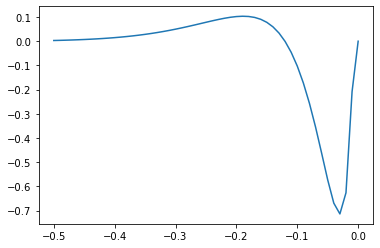

In [57]:
plt.plot(-tt*dt, w_true)

In [6]:
def build_raised_cosine_matrix(df, dims, endpoints=None, b=1.5):
    
    def nl(x):
        return np.log(x + 1e-20)
    
    def invnl(x):
        return np.exp(x) - 1e-20
    
    def raised_cosine_basis(x, c, dc):
        return 0.5 * (np.cos(np.maximum(-np.pi,np.minimum(np.pi,(x-c)*np.pi/dc/2)))+1)
    
    if endpoints is None:
        endpoints = np.array([0.1, dims/2])
    elif type(endpoints) is list:
        endpoints= np.array(endpoints)
    
    yendpoints = nl(endpoints + b)
    dctr = np.diff(yendpoints) / (df - 1)
    ctrs = np.linspace(yendpoints[0], yendpoints[1], df)
    maxt = invnl(yendpoints[1]+2*dctr) - b
    ttgrid = np.arange(0, dims)
    nt = len(ttgrid)
    
    xx = np.tile(nl(ttgrid+b)[:, np.newaxis], (1, df))
    cc = np.tile(ctrs, (nt, 1))
    
    basis = raised_cosine_basis(xx, cc, dctr)
    
    return basis[::-1]

In [54]:
df = 7 # number of basis vectors
# dims = 51
endpoints = np.array([0.1, 10.]) # location of 1st and last cosines
b = 0.5 # nonlinear stretch factor (larger => more linear)

B = build_raised_cosine_matrix(dims=dims, df=df, endpoints=endpoints, b=b)
S, _ = cr(x=np.arange(dims), df=df)

b_rc = np.linalg.solve(B.T @ B, B.T @ w_true)
w_rc = B @ b_rc

b_nc = np.linalg.solve(S.T @ S, S.T @ w_true)
w_nc = S @ b_nc

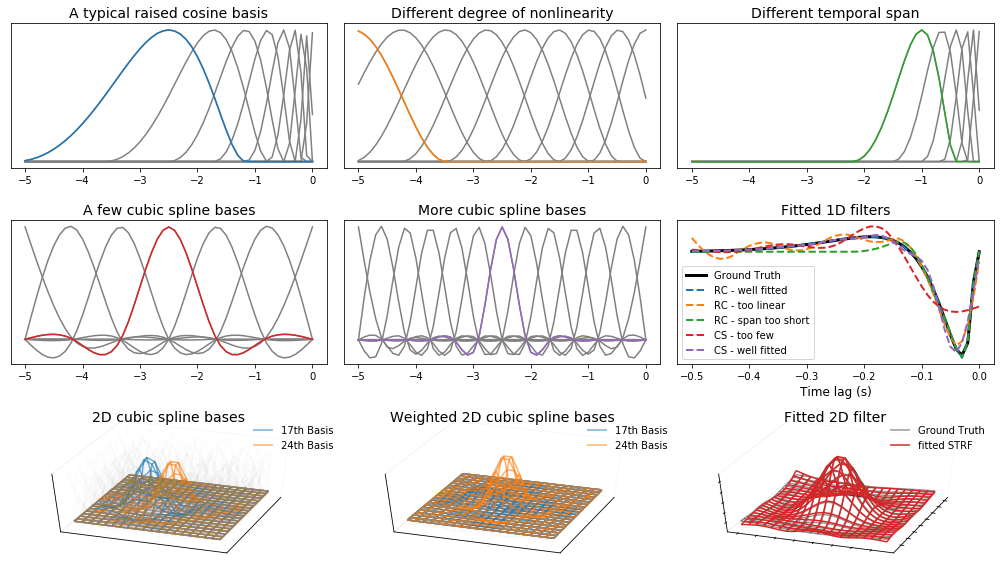

In [57]:
fontsize=14

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 8))

ax_fitted = fig.add_subplot(3, 3, 6)
# fig, ax = plt.subplots(3, 3, figsize=(12, 8))
# ax = ax.flatten()

ax_fitted.plot(-tt * dt, w_true, color='black', linewidth=3, label='Ground Truth', linestyle='-')
ax_fitted.set_title('Fitted 1D filters', fontsize=fontsize)
ax_fitted.set_xlabel('Time lag (s)', fontsize=12)

labels = ['RC - well fitted', 'RC - too linear', 'RC - span too short', 'CS - too few', 'CS - well fitted']

dims = len(w_true)
dfs = [9, 9, 6]
lastendpoint = [25., 51., 10.]
bs = [1.5, 50., 2.]
for i in range(3):
    
    ax = fig.add_subplot(3, 3, i+1)
    
    df = dfs[i] # number of basis vectors
    # dims = 51
    endpoints = np.array([0.1, lastendpoint[i]]) # location of 1st and last cosines
    b = bs[i] # nonlinear stretch factor (larger => more linear)

    B = build_raised_cosine_matrix(dims=dims, df=df, endpoints=endpoints, b=b)
    ax.plot(-tt, B, color='grey')
    ax.plot(-tt, B[:, -1], color=f'C{i}')
    if i == 0:
        ax.set_title('A typical raised cosine basis', fontsize=fontsize)
#         ax.set_ylabel('Raised Cosine', fontsize=13)
    elif i == 1:
        ax.set_title('Different degree of nonlinearity', fontsize=fontsize)
    elif i == 2:
        ax.set_title('Different temporal span', fontsize=fontsize)

    ax.set_yticks([])
        
    b_rc = np.linalg.solve(B.T @ B, B.T @ w_true)
    w_rc = B @ b_rc
    ax_fitted.plot(-tt * dt, w_rc, linewidth=2, label=labels[i], linestyle='--')

    
for i, df in enumerate([7, 13]):
    
    ax = fig.add_subplot(3, 3, i+3+1)
    S, _ = cr(x=np.arange(dims), df=df)
    
    b_rc = np.linalg.solve(S.T @ S, S.T @ w_true)
    w_rc = S @ b_rc
    
    ax.plot(-tt, S, color='gray')
    ax.plot(-tt, S[:, int(S.shape[1]/2)], color=f'C{i+3}')
    ax_fitted.plot(-tt * dt, w_rc, linewidth=2, label=labels[i+3], linestyle='--')
    
    ax.set_yticks([])
    
    if i+3 == 3:
        ax.set_title('A few cubic spline bases', fontsize=fontsize)
#         ax.set_ylabel('Natural Cubic Spline', fontsize=13)
    elif i+3 == 4:
        ax.set_title('More cubic spline bases', fontsize=fontsize)



ax_2d_left = fig.add_subplot(3, 3, 7, projection='3d')
ax_2d_mid = fig.add_subplot(3, 3, 8, projection='3d')
ax_2d_right = fig.add_subplot(3, 3, 9, projection='3d')



ax_fitted.legend()
ax_fitted.set_yticks([])

dims = [20, 20]
df= [7, 7] 
smooth = 'cr'
S = build_spline_matrix(dims=dims, df=df, smooth='cr', lam=[0., 0.])

w = mexicanhat2d(dims=dims, std=[5,5])
stim = noise2d(n_samples=3000,dims=dims, design_matrix=False)
y = get_response(stim.reshape(3000, 400), w.flatten())

spl = splineLG(stim.reshape(3000, 400), y, dims=dims, df=df)


X = np.arange(0, 20, 1)
Y = np.arange(0, 20, 1)
X, Y = np.meshgrid(X, Y)

for i in range(0, 49,1):
    ax_2d_left.plot_wireframe(X, Y, S[:, i].reshape(dims), alpha=0.02, color='grey')

# for i in range(0, 49):
ax_2d_left.plot_wireframe(X, Y, S[:, 17].reshape(dims), alpha=0.6, color='C0', label='17th Basis')
ax_2d_left.plot_wireframe(X, Y, S[:, 24].reshape(dims), alpha=0.6, color='C1', label='24th Basis')
# ax_2d_left.plot_wireframe(X, Y, S[:, 31].reshape(dims), alpha=0.6, color='C2', label='31th Basis')
ax_2d_left.legend(frameon=False, loc=1, bbox_to_anchor=(1.05, 1))


ax_2d_left.set_xticks([])
ax_2d_left.set_yticks([])
ax_2d_left.set_zticks([])
ax_2d_left.set_title('2D cubic spline bases', fontsize=fontsize)
# ax_2d_left.set_zlabel('2D natural cubic spline')

ax_2d_left.legend(frameon=False, loc=1, bbox_to_anchor=(1.05, 1))

w = mexicanhat2d(dims=dims, std=[5,5])
stim = noise2d(n_samples=3000,dims=dims, design_matrix=False)
y = get_response(stim.reshape(3000, 400), w.flatten())

spl = splineLG(stim.reshape(3000, 400), y, dims=dims, df=df)


ax_2d_right.plot_wireframe(X, Y, w.reshape(dims), alpha=0.4, color='black', label='Ground Truth')
ax_2d_right.plot_wireframe(X, Y, spl.w_spl.reshape(dims), alpha=1., color='C3', label='fitted STRF')


for i in range(0, 49,1):
    ax_2d_mid.plot_wireframe(X, Y, S[:, i].reshape(dims) * spl.b_spl[i], alpha=0.05, color='grey')

# for i in range(0, 49):
ax_2d_mid.plot_wireframe(X, Y, S[:, 17].reshape(dims) * spl.b_spl[17], alpha=0.6, color='C0', label='17th Basis')
ax_2d_mid.plot_wireframe(X, Y, S[:, 24].reshape(dims) * spl.b_spl[24], alpha=0.6, color='C1', label='24th Basis')



ax_2d_mid.set_xticks([])
ax_2d_mid.set_yticks([])
ax_2d_mid.set_zticks([])
ax_2d_mid.set_title('Weighted 2D cubic spline bases', fontsize=fontsize)
# ax_2d_left.set_zlabel('2D natural cubic spline')

ax_2d_mid.legend(frameon=False, loc=1, bbox_to_anchor=(1.05, 1))

# ax_2d_right.plot_wireframe(X, Y, spl.w_spl.reshape(dims), alpha=0.9, color='C3', label='fitted STRF')


ax_2d_right.legend(frameon=False,)
ax_2d_right.set_title('Fitted 2D filter', fontsize=fontsize)

ax_2d_left.view_init(45, 20)
ax_2d_mid.view_init(45, 20)
ax_2d_right.view_init(45, 20)

for ax in [ax_2d_left, ax_2d_mid, ax_2d_right]:

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])
#     ax.set_xlabel('x', fontsize=16)
#     ax.set_ylabel('y', fontsize=16)
#     ax.set_zlabel('z', fontsize=16)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
fig.tight_layout()

fig.savefig('./figs/Figure1.pdf')